# RandomForest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from math import inf
from collections import OrderedDict
from abc import ABC, abstractmethod

plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

## Напишем свою реализацию случайного леса

### Дерево из прошлого ноутбука с дополнительным параметром max_features

In [2]:
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [3]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

    def predict(self, X):
        if X[self.index] <= self.t:
            return self.true_branch.predict(X)
        else:
            return self.false_branch.predict(X)

In [4]:
class Leaf(ABC):
    def __init__(self, labels):
        self.labels = labels
        self._get_prediction(labels)

    def predict(self, X=None):
        return self.prediction

    @abstractmethod
    def _get_prediction(self, labels):
        self.prediction = None

In [5]:
class TreeCutter:

    def cut_leafs(self, tree, n, cut_last_node=False):
        self._level_list = OrderedDict()
        self._read_node(tree)
        n = self._cut_leafs(n)
        if n > 0 and cut_last_node:
            leaf = self._create_leaf_from_node(tree)
            if leaf is not None:
                return leaf

        return tree

    def _read_node(self, node, parent=None, level=0):
        if isinstance(node, Node):
            self._add_node(node, parent, level)

            if isinstance(node.true_branch, Node):
                self._read_node(node.true_branch, node, level+1)

            if isinstance(node.false_branch, Node):
                self._read_node(node.false_branch, node, level+1)

    def _add_node(self, node, parent, level):
        if level not in self._level_list:
            self._level_list[level] = []

        self._level_list[level].append((node, parent))

    def _cut_leafs(self, n):
        while n > 0 and len(self._level_list):
            _, level = self._level_list.popitem()

            while n > 0 and len(level):
                node, parent = level.pop()
                if not isinstance(parent, Node):
                    continue

                leaf = self._create_leaf_from_node(node)
                if leaf is not None:
                    n -= self._replace_node_by_leaf(parent, node, leaf)

        return n

    def _create_leaf_from_node(self, node):
        cut_node = True
        cut_node = cut_node and isinstance(node.true_branch, Leaf)
        cut_node = cut_node and isinstance(node.false_branch, Leaf)

        if cut_node:
            true_labels = node.true_branch.labels
            false_labels = node.false_branch.labels
            labels = np.hstack((true_labels, false_labels))
            return type(node.true_branch)(labels)

        return None

    def _replace_node_by_leaf(self, parent, node, leaf):
        if parent.true_branch is node:
            parent.true_branch = leaf
            return 1

        elif parent.false_branch is node:
            parent.false_branch = leaf
            return 1

        return 0

In [6]:
class DecisionTree(ABC):

    def __init__(self,
                 max_depth=None,
                 max_features=None,
                 min_samples_leaf=1,
                 max_leaf_count=None,
                 min_impurity_decrease=0.0):

        self._tree = None
        self._leaf_count = 0

        self._max_features = max_features
        self._min_samples_leaf = min_samples_leaf
        self._max_leaf_count = max_leaf_count
        self._min_impurity_decrease = min_impurity_decrease

        if max_depth is None:
            self._max_depth = inf
        else:
            self._max_depth = max(max_depth - 1, 0)

        if type(self._max_features) is str:
            allowed_feat = ['sqrt',]
            self._max_features = self._max_features.lower()
            if self._max_features not in allowed_feat:
                raise ValueError(
                    f"Unknown value {self._max_features} for max_features!"
                )

    @abstractmethod
    def _criterion(self, labels):
        pass

    @abstractmethod
    def _Leaf(self, labels):
        pass

    @abstractmethod
    def _Node(self, index, t, true_branch, false_branch):
        pass

    def __str__(self):
        return self._print_tree(self._tree)

    def fit(self, X, y):
        self._leaf_count = 0
        self._tree = self._build_tree(X, y)

        if self._max_leaf_count is not None:
            n = self._leaf_count - self._max_leaf_count
            if n > 0:
                cutter = TreeCutter()
                self._tree = cutter.cut_leafs(self._tree, n)

    def predict(self, X):
        return np.apply_along_axis(self._tree.predict, 1, np.array(X))

    def _build_tree(self, data, labels, level=0):
        gain, t, index = self._find_best_split(data, labels)

        stop_flag = False
        stop_flag = stop_flag or gain == 0
        stop_flag = stop_flag or gain < self._min_impurity_decrease
        stop_flag = stop_flag or level > self._max_depth

        if stop_flag:
            self._leaf_count += 1
            return self._Leaf(labels)

        true_data, false_data, true_labels, false_labels = self._split(
            data, labels, index, t
        )

        true_branch = self._build_tree(true_data, true_labels, level+1)
        false_branch = self._build_tree(false_data, false_labels, level+1)
        return self._Node(index, t, true_branch, false_branch)

    def _find_best_split(self, data, labels):
        best_gain, best_t, best_index = 0, None, None

        h = self._criterion(labels)
        for index in self._get_features(data.shape[1]):

            for t in np.unique(data[:, index]):
                _, _, left_labels, right_labels = self._split(
                    data, labels, index, t
                )

                if len(left_labels) < self._min_samples_leaf:
                    continue

                if len(right_labels) < self._min_samples_leaf:
                    continue

                p = len(left_labels) / len(labels)
                left_h = self._criterion(left_labels)
                right_h = self._criterion(right_labels)
                current_gein = h - (p * left_h) - ((1 - p) * right_h)

                if current_gein > best_gain:
                    best_gain, best_t, best_index = current_gein, t, index

        return best_gain, best_t, best_index

    def _split(self, data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        return data[left], data[right], labels[left], labels[right]

    def _get_features(self, data_len):
        if self._max_features is None:
            n_feat = data_len

        elif type(self._max_features) is str:
            if self._max_features == 'sqrt':
                n_feat = int(np.sqrt(data_len))

        elif type(self._max_features) is float:
            n_feat = int(data_len * self._max_features)

        else:
            n_feat = int(self._max_features)

        n_feat = max(n_feat, 1)
        n_feat = min(n_feat, data_len)

        indexes = np.arange(data_len)
        np.random.shuffle(indexes)
        return indexes[:n_feat]

    def _print_tree(self, node, spacing=""):
        text = ''

        # Если лист, то выводим его прогноз
        if isinstance(node, Leaf):
            text += ColorText.ORANGE + spacing + ' ЛИСТ'
            text += ': прогноз = ' + str(node.prediction)
            text += ', объектов = ' + str(len(node.labels))
            text += ColorText.END
            return text

        # Выведем значение индекса и порога на этом узле
        text += ColorText.GREEN + spacing + 'УЗЕЛ'
        text += ': индекс = ' + str(node.index)
        text += ', порог = ' + str(round(node.t, 2))
        text += ColorText.END

        # Рекурсионный вызов функции на положительном поддереве
        text += f'\n{spacing}--> Левая ветка:\n'
        text += self._print_tree(node.true_branch, spacing + "   ")

        # Рекурсионный вызов функции на положительном поддереве
        text += f'\n{spacing}--> Правая ветка:\n'
        text += self._print_tree(node.false_branch, spacing + "   ")

        return text

In [7]:
class ClassifierLeaf(Leaf):

    def _get_prediction(self, labels):
        values, counts = np.unique(labels, return_counts=True)
        self.prediction = values[counts.argmax()]

In [8]:
def gini(labels):
    _, counts = np.unique(labels, return_counts=True)
    p = counts / sum(counts)
    return 1 - sum(p**2)

In [9]:
def entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    p = counts / sum(counts)
    return -sum(p * np.log2(p))

In [10]:
class DecisionTreeClassifier(DecisionTree):

    def __init__(self, criterion='gini', **kwargs):
        super().__init__(**kwargs)

        criterion = criterion.lower()
        criterion_list = ['gini', 'entropy']
        if criterion == 'gini':
            self._selected_criterion = gini

        elif criterion == 'entropy':
            self._selected_criterion = entropy

        else:
            error = f'Unknown criterion {criterion} for DecisionTreeClassifier'
            error += f' (criterion not in [{", ".join(criterion_list)}])!'
            raise ValueError(error)

    def _criterion(self, labels):
        return self._selected_criterion(labels)

    def _Leaf(self, labels):
        return ClassifierLeaf(labels)

    def _Node(self, index, t, true_branch, false_branch):
        return Node(index, t, true_branch, false_branch)

### Класс реализующий бэггинг

In [11]:
def vote(labels):
    values, counts = np.unique(labels, return_counts=True)
    return values[counts.argmax()]

In [12]:
class Bagging:

    def __init__(self,
                 estimator=None,
                 n_estimators=100,
                 random_state=None,
                 prediction='voting',
                 **kwargs) -> None:

        self._estimators = []

        self._estimator = estimator
        self._n_estimators = n_estimators
        self._random_state = random_state
        self._estimator_args = kwargs
        self._prediction = prediction.lower()

        if self._prediction not in ['voting', 'mean']:
            error = f'Unknown value for {prediction} for prediction param!'
            error += ' (value not in ("voting", "mean"))'
            raise ValueError(error)

    @property
    def oob(self):
        return self._oob

    @property
    def oob_true(self):
        return self._oob[0]

    @property
    def oob_pred(self):
        return self._oob[1]

    def fit(self, X, y):
        oob_values = {}
        self._estimators = []

        np.random.seed(self._random_state)
        X, y = np.array(X), np.array(y)
        for _ in range(self._n_estimators):
            data, labels, oob = self._get_bootstrap(X, y)
            estimator = self._estimator(**self._estimator_args)
            estimator.fit(data, labels)
            self._estimators.append(estimator)

            oob_pred = estimator.predict(oob[1])
            for idx in range(len(oob[0])):
                index = oob[0][idx]
                if index not in oob_values:
                    oob_values[index] = {'real': oob[2][idx], 'pred': []}

                oob_values[index]['pred'].append(oob_pred[idx])

        oob = []
        for row in oob_values.values():
            real = row['real']
            pred = self._get_prediction(row['pred'])
            oob.append(np.array([real, pred]))

        self._oob = np.array(oob).T

    def predict(self, X):
        y_pred = []
        for estimator in self._estimators:
            y_pred.append(estimator.predict(X))

        y_pred = np.array(y_pred).T
        results = []
        for row in y_pred:
            results.append(self._get_prediction(row))

        return np.array(results)

    def _get_prediction(self, y_pred):
        y_pred = np.array(y_pred)
        if self._prediction == 'voting':
            return vote(y_pred)

        elif self._prediction == 'mean':
            return np.mean(y_pred)

    def _get_bootstrap(self, X, y):
        n_samples = X.shape[0]
        all_indexes = np.arange(n_samples)
        rand_indexes = np.random.randint(n_samples, size=(n_samples,))
        oob_indexes = all_indexes[~np.isin(all_indexes, rand_indexes)]

        oob = (oob_indexes, X[oob_indexes], y[oob_indexes])
        return X[rand_indexes], y[rand_indexes], oob

### Класс случайного леса

In [13]:
class RandomForestClassifier(Bagging):
    def __init__(self,
                 n_estimators=100,
                 random_state=None,
                 max_features='sqrt',
                 **kwargs) -> None:

        super().__init__(estimator=DecisionTreeClassifier,
                         prediction='voting',
                         n_estimators=n_estimators,
                         random_state=random_state,
                         max_features=max_features,
                         **kwargs)

## Посмотрим как влияют гиперпараметры на работу модели

На самом деле разбиение на train/test не имеет смысла т.к. в модели реализован Out-of-Bag и метрики можно считать по нему, но мы проверим на сколько значения на отложенной выборке отличаются от OOB

In [14]:
X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

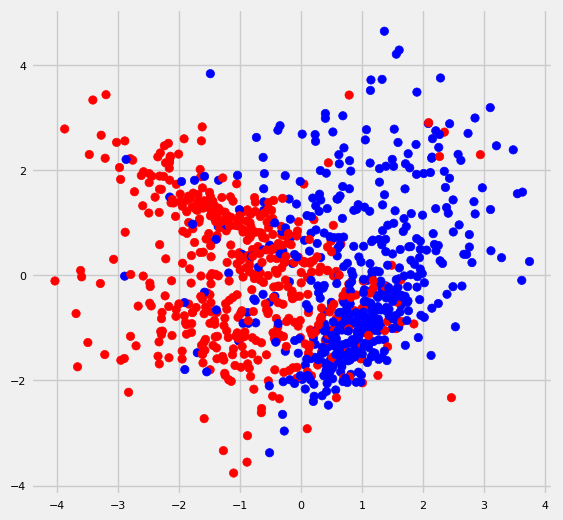

In [15]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], X)),
            list(map(lambda x: x[1], X)), 
            c=y, cmap=colors);

In [16]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [17]:
def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

Trees count = 1
Out-of-Bag accuracy = 0.7638888888888888


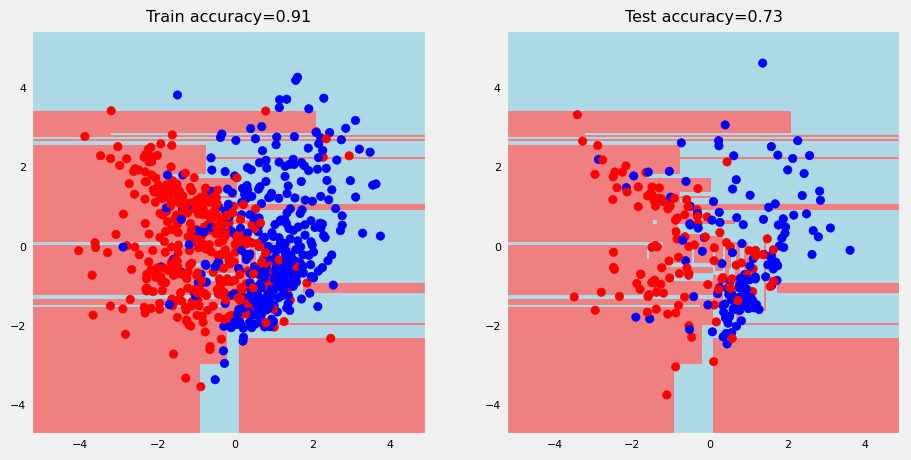

Trees count = 3
Out-of-Bag accuracy = 0.7821428571428571


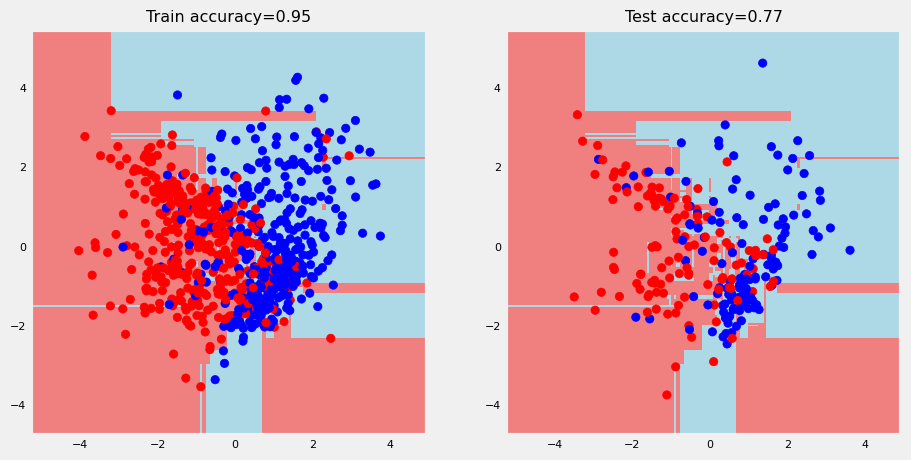

Trees count = 10
Out-of-Bag accuracy = 0.8026845637583893


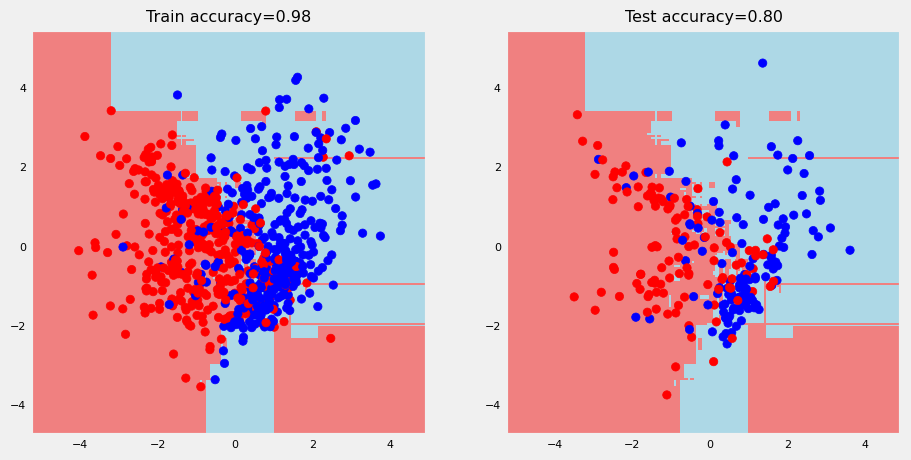

Trees count = 50
Out-of-Bag accuracy = 0.8146666666666667


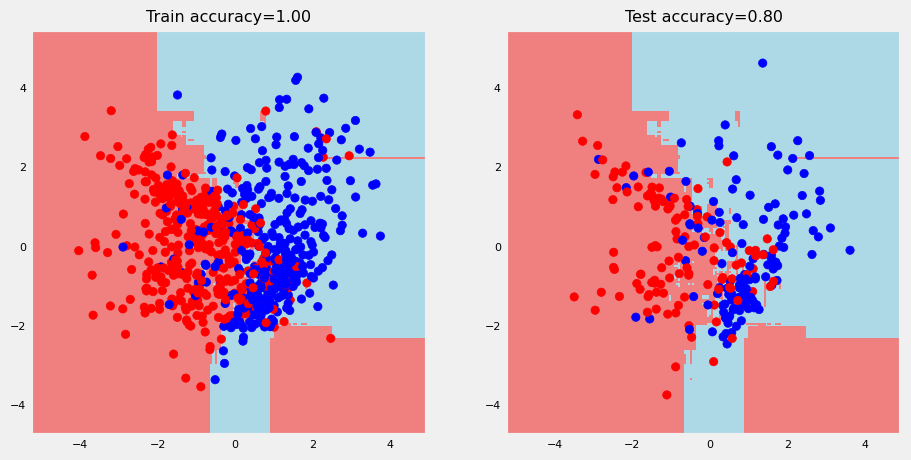

Trees count = 100
Out-of-Bag accuracy = 0.8186666666666667


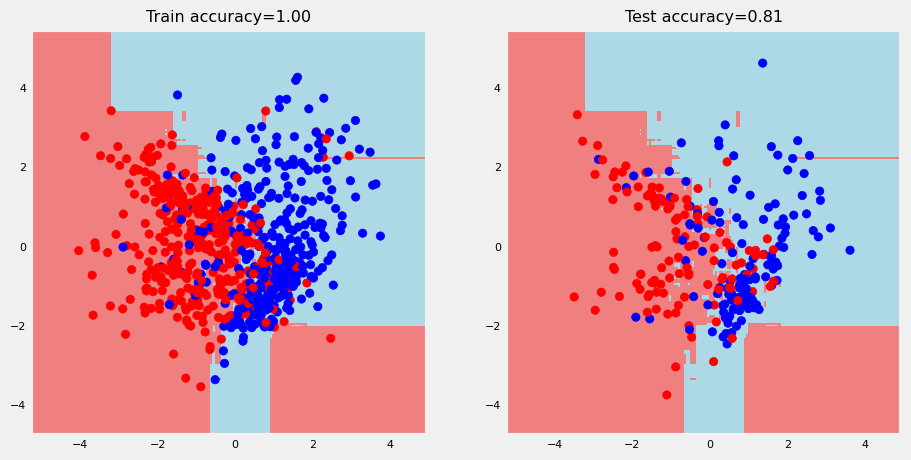

Trees count = 200
Out-of-Bag accuracy = 0.812


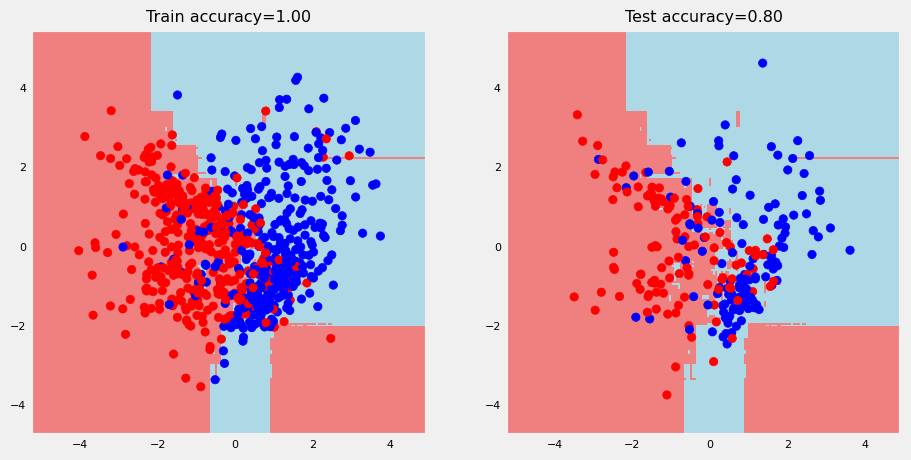

In [18]:
for n_estimators in [1, 3, 10, 50, 100, 200]:
    forest = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    forest.fit(X_train, y_train)
    
    train_accuracy = accuracy(y_train, forest.predict(X_train))
    test_accuracy = accuracy(y_test, forest.predict(X_test))

    plt.figure(figsize=(10, 5))

    print(f'Trees count = {n_estimators}')
    print(f'Out-of-Bag accuracy = {accuracy(*forest.oob)}')

    # график обучающей выборки
    plt.subplot(1, 2, 1)
    xx, yy = get_meshgrid(X_train)
    mesh_predictions = np.array(forest.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1, 2, 2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    
    plt.show()

Можно заметить, что случайный лес значительно более устойчив к переобучению, чем решающее дерево. При увеличении количества деревьев качество на тесте не падает. При этом сами деревья никак не ограничены.

Точность на Out-of-Bag очень похожа на значение полученное на отложенной выборке, при этом она считается на данных для обучения. Такой подход позволяет обучить алгоритм на всей выборке и не выделять данные для проверки качества модели.

In [19]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X, y)
print(accuracy(*forest.oob))

0.819
